# Signaling pathways

In the following we will implement and analyse the simple signaling motives from the lecture
- phosphorylation cycle
- two-component system

In addition we will have a look at a real world example. A MAP kinase model.

We will use `tellurium` to encode the model, i.e., the ODEs and for simulation. For documentation see https://tellurium.readthedocs.io/en/latest/notebooks.html#modeling-case-studies

In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Building ODE models
### 1.1 Modeling in a nutshell
**Basic steps**: 
- write down the players (**species Si**) in your system
- write down the **processes vi** which influence your species and the **stoichiometry** (number of species consumed/produced via the process)
- write down mathematical equations for the **processes**
- equations define the **rates** of the processes, defining how fast the process changes the species

**Processes**
- require stoichiometry and rate law (kinetics)
$$v1: S1 \rightarrow S2$$
$$v1 = k1 \cdot S1$$

**System of ordinary differential equations (ODEs)**

The result is a list of mathematical equations (differential equations)
* can be solved with numerical methods
* results in time courses, i.e., the time-dependent 

$$\frac{dS1}{dt} = -v1 = -k1 \cdot S1$$  
$$\frac{dS2}{dt} = v1 = k1 \cdot S1$$

**Main types of equations**
* Mass-Action kinetics
* Michaelis-Menten Kinetics (irreversible & reversible)
* Hill equations (cooperativity)
* (Non-)Competitive Inhibition

### 1.2 Model definition

In [42]:
import tellurium as te
import pandas as pd

In [43]:
# model definition
model = te.loada(f"""
model example1()
  // compartments and species
  species S1, S2;

  // processes
  v1: S1 -> S2; k1*S1;
  
  // initial conditions
  S1 = 10.0;
  
  // parameters
  k1 = 0.1;
end
""")
print(te.sbmlToAntimony(model.getSBML()))

// Created by libAntimony v2.11.0
model *example1()

  // Compartments and Species:
  species S1, S2;

  // Reactions:
  v1: S1 -> S2; k1*S1;

  // Species initializations:
  S1 = 10;
  S2 = ;

  // Variable initializations:
  k1 = 0.1;

  // Other declarations:
  const k1;
end



### 1.3 simulation

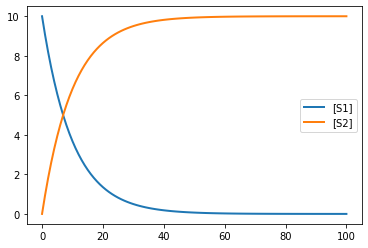

,time,[S1],[S2]
0,0.0,10.000000,0.000000
1,1.0,9.048378,0.951622
2,2.0,8.187310,1.812690
3,3.0,7.408184,2.591816
4,4.0,6.703199,3.296801
...,...,...,...
96,96.0,0.000677,9.999323
97,97.0,0.000613,9.999387
98,98.0,0.000554,9.999446
99,99.0,0.000502,9.999498


In [56]:
model.reset()
s = model.simulate(start=0, end=100, steps=100)
model.plot(s)
s = pd.DataFrame(s, columns=s.colnames)
display(s)

## 2. Phosphorylation cycle
One of the most important signaling motives are protein phosphorylation cycles, i.e., a post-translational modification of a protein in which an amino acid residue is phosphorylated by a protein kinase, and dephosphorylated by a protein phosphatase.

Simple models follow mass-action kinetics. For example the following simple phosphorylation cycle where the kinase activity represents the signal $S$, and the activity of the phosphatase is assumed to be constant (and included in the rate constant $k_2$)

<img src="../images/phosphorylation_cycle2.png" width="200"/>

\begin{equation}
    v_1 = k_1 \cdot S \cdot R \\
    v_2 = k_2 \cdot R_p \\
    \frac{dR_p}{dt} = v_1 - v_2 = k_1 \cdot S \cdot R - k_2 \cdot R_p \\ 
    \frac{dR}{dt} = -v_1 + v_2 = -\frac{dR}{dt}
\end{equation}

The system exhibits mass conservation $R_p + R = R^T$, where $R^T$ denotes the amount of total protein.

\begin{equation}
    \frac{d (R + R_p)}{dt} = 0
\end{equation}

### 2.1 Build model phosphorylation cycle

In [53]:
import tellurium as te
import pandas as pd
from IPython.display import display, HTML

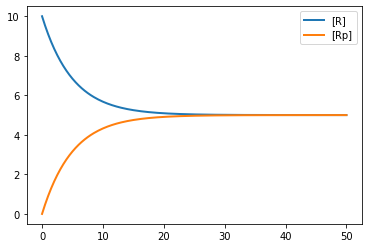

,time,[R],[Rp]
0,0.00,10.000000,0.000000
1,0.25,9.756147,0.243853
2,0.50,9.524188,0.475812
3,0.75,9.303541,0.696459
4,1.00,9.093654,0.906346
...,...,...,...
196,49.00,5.000279,4.999721
197,49.25,5.000265,4.999735
198,49.50,5.000252,4.999748
199,49.75,5.000240,4.999760


In [54]:
model_pcycle = te.loada(f"""
model pcycle()
  // compartments and species
  species R, Rp;

  // reactions
  v1: R -> Rp; k1*S*R;
  v2: Rp -> R; k2*Rp;
  
  // initial conditions
  R = 10.0; Rp = 0.0;
  
  // parameters
  k1 = 0.1; k2 = 0.1;
  S = 1.0;  
end
""")

# print(te.sbmlToAntimony(model_pcycle.getSBML()))
s = model_pcycle.simulate(start=0, end=50, steps=200)
model_pcycle.plot(s)

### 2.2 Check mass balance
- to check the mass balance we add an assignment rule to the model
- to be able to access the variables in the results we `Rt` to the selections

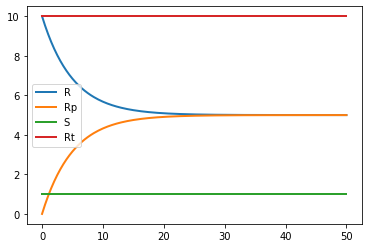

,time,R,Rp,S,Rt
0,0.00,10.000000,0.000000,1.0,10.0
1,0.25,9.756147,0.243853,1.0,10.0
2,0.50,9.524188,0.475812,1.0,10.0
3,0.75,9.303541,0.696459,1.0,10.0
4,1.00,9.093654,0.906346,1.0,10.0
...,...,...,...,...,...
196,49.00,5.000279,4.999721,1.0,10.0
197,49.25,5.000265,4.999735,1.0,10.0
198,49.50,5.000252,4.999748,1.0,10.0
199,49.75,5.000240,4.999760,1.0,10.0


In [100]:
model_pcycle = te.loada(f"""
model pcycle()
  // compartments and species
  species R, Rp;

  // reactions
  v1: R -> Rp; k1*S*R;
  v2: Rp -> R; k2*Rp;
  
  // initial conditions
  R = 10.0; Rp = 0.0;
  
  // parameters
  k1 = 0.1; k2 = 0.1;
  S = 1.0;  
  
  // rules
  Rt := R + Rp
end
""")

# print(te.sbmlToAntimony(model_pcycle.getSBML()))

selections = ["time", "R", "Rp", "S", "Rt"]

s = model_pcycle.simulate(start=0, end=50, steps=200, selections=selections)
model_pcycle.plot(s)
s = pd.DataFrame(s, columns=s.colnames)
display(s)

### 2.3 Parameter scan
A typical task in a simulation study is to scan parameters and check the influence of parameters on the model.

In the following we will change the parameter of the kinase `k1`

In [104]:
import numpy as np
from matplotlib import pyplot as plt

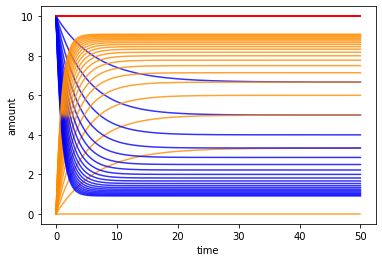

In [105]:
model.resetToOrigin()
k1_vec = np.linspace(0, 1, num=21)
# k1_vec = np.logspace(-10, 1, num=21)

# run parameter scan
results = []
for k1 in k1_vec:
    # print(k1)
    model_pcycle.reset()
    model_pcycle["k1"] = k1
    s = model_pcycle.simulate(start=0, end=50, steps=200)
    s = pd.DataFrame(s, columns=s.colnames)
    results.append(s)
    
# create plot
f, ax = plt.subplots()
kwargs = {"alpha": 0.8}
for k, s in enumerate(results):
    ax.plot(s.time, s.R, color="blue", **kwargs)
    ax.plot(s.time, s.Rp, color="darkorange", **kwargs)
    ax.plot(s.time, s.Rt, color="red", **kwargs)

ax.set_xlabel("time")
ax.set_ylabel("amount")

plt.show()

**Important things**
- numerical simulations (with floating point values and certain accuracy)
- steady state concentration depend on the $k_1$ parameter
- the higher the phosphorylation rate the faster the steady state is reached
- mass balance is conserved for changing of parameters

Often one is interested in changes in steady state (or other system properties with parameters).
- for instance how do the steady state values of R and Rp change with $k_1$

In [114]:
# collect steady state values
R_ss = np.zeros_like(k1_vec)
Rp_ss = np.zeros_like(k1_vec)
Rt_ss = np.zeros_like(k1_vec)

for k, s in enumerate(results):
    R_ss[k] = s.R.values[-1]
    Rp_ss[k] = s.Rp.values[-1]
    Rt_ss[k] = s.Rt.values[-1]

f, ax = plt.subplots()
kwargs = {"marker": "s"}
ax.plot(k1_vec, R_ss, color="blue", **kwargs)
ax.plot(k1_vec, Rp_ss, color="darkorange", **kwargs)
ax.plot(k1_vec, Rt_ss, color="red", **kwargs)
ax.set_xlabel("k1")
ax.set_ylabel("amount")
# ax.set_xscale("log")
plt.show()

IndexError: index 21 is out of bounds for axis 0 with size 21

### 2.4 Steady state (dependency on signal)
Steady state of the system is given by

\begin{equation}
\frac{dR_p}{dt} = k_1 \cdot S \cdot R - k_2 \cdot R_p = k1 \cdot S \cdot (R^T - R_p) - k_2 \cdot R_p = 0 \\
R_p^0 = R^T \cdot \frac{S}{S + \frac{k_2}{k_1}}  \\
R^0 = R^T - R_p^0 = R^T \cdot \left(1- \frac{S}{S + \frac{k_2}{k_1}} \right) \\
\end{equation}

Note that the dependence on the kinase activity (signal) is hyperbolic, whereas the dependence on total protein is linear.

In the following we compare the analytical solution against the numerical solution (vs actual steady state simulation).

In [115]:
# make sure the model is reset
model_pcycle.resetToOrigin()
# print model (to check parameter values)
print(te.sbmlToAntimony(model_pcycle.getSBML()))

// Created by libAntimony v2.11.0
model *pcycle()

  // Compartments and Species:
  species R, Rp;

  // Assignment Rules:
  Rt := R + Rp;

  // Reactions:
  v1: R -> Rp; k1*S*R;
  v2: Rp -> R; k2*Rp;

  // Species initializations:
  R = 10;
  Rp = 0;

  // Variable initializations:
  k1 = 0.1;
  S = 1;
  k2 = 0.1;

  // Other declarations:
  var Rt;
  const k1, S, k2;
end



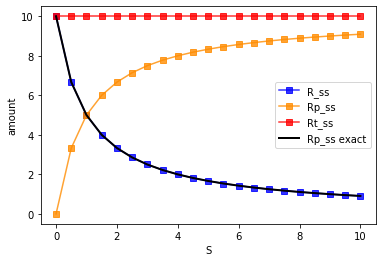

In [125]:
S_vec = np.linspace(0, 10, num=21)
# S_vec = np.logspace(-3, 3, num=100)

R_ss = np.zeros_like(S_vec)
Rp_ss = np.zeros_like(S_vec)
Rt_ss = np.zeros_like(S_vec)

# run parameter scan
results = []
for k, S in enumerate(S_vec):
    model_pcycle.reset()
    model_pcycle["S"] = S
    s = model_pcycle.simulate(start=0, end=50, steps=100)
    s = pd.DataFrame(s, columns=s.colnames)
    
    # store results
    results.append(s)

    # collect steady state values
    R_ss[k] = s.R.values[-1]
    Rp_ss[k] = s.Rp.values[-1]
    Rt_ss[k] = s.Rt.values[-1]

f, ax = plt.subplots()
kwargs = {"marker": "s", "alpha": 0.8}

ax.plot(S_vec, R_ss, color="blue", label="R_ss", **kwargs)
ax.plot(S_vec, Rp_ss, color="darkorange", label="Rp_ss", **kwargs)
ax.plot(S_vec, Rt_ss, color="red", label="Rt_ss", **kwargs)

# analytical solution
Rp_ssf = model_pcycle.Rt * (1-S_vec/(S_vec + model_pcycle.k2/model_pcycle.k1))
ax.plot(S_vec, Rp_ssf, "-k", label="Rp_ss exact", linewidth="2")

ax.legend()
ax.set_xlabel("S")
ax.set_ylabel("amount")
# ax.set_xscale("log")
plt.show()

### 2.5 Steady state sensitivity (signal)
Steady state of the system is given by

\begin{equation}
R^0 = R^T - R_p^0 = R^T \cdot \left(1- \frac{S}{S + \frac{k_2}{k_1}} \right) \\
\end{equation}

Dependency on signal
\begin{equation}
\frac{\partial R_p^0}{\partial S} |_{S^*} = \frac{R^T(S+\frac{k_2}{k_1}) - R^T \cdot S}{\left(S + \frac{k_2}{k_1}\right)^2}|_{S^*} = \frac{ \frac{k_2}{k_1} \cdot R^T}{ \left(S^* + \frac{k_2}{k_1}\right)^2}
\end{equation}

\begin{equation}
    \frac{\partial \ln R_p^0}{\partial ln S} |_{S^*} = \frac{S}{R_p^0}\cdot \frac{\partial R_p^0}{\partial S}|_{S^*} = \frac{S^*}{R^T \cdot \left(1- \frac{S^*}{S^* + \frac{k_2}{k_1}}\right)} \cdot \frac{\frac{k_2}{k_1} R^T}{\left(S^* + \frac{k_2}{k_1} \right)^2} = \frac{\frac{k_2}{k_1}}{S^* + \frac{k_2}{k_1}} = \frac{1}{1 + \frac{S^*}{\frac{k_2}{k_1}}}
\end{equation}

/home/mkoenig/envs/mcp/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning:

invalid value encountered in double_scalars

/home/mkoenig/envs/mcp/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning:

invalid value encountered in double_scalars

/home/mkoenig/envs/mcp/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in double_scalars



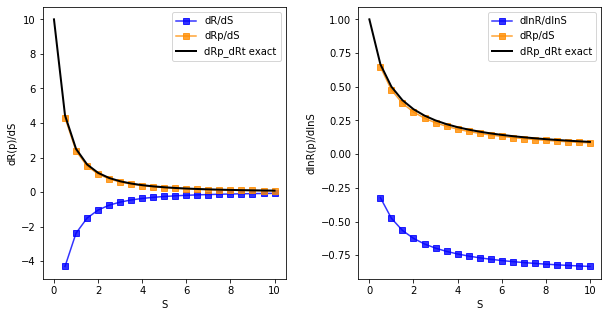

In [173]:
S_vec = np.linspace(0, 10, num=21)
# S_vec = np.logspace(-3, 3, num=100)

dR_dRt = np.zeros_like(S_vec)
dRp_dRt = np.zeros_like(S_vec)
ln_dR_dRt = np.zeros_like(S_vec)
ln_dRp_dRt = np.zeros_like(S_vec)

# change
delta = 0.1  # increase parameter 1%

# run parameter scan
results = []
for k, S in enumerate(S_vec):
    # complete reset
    model_pcycle.resetToOrigin()
    model_pcycle["S"] = S
    s = model_pcycle.simulate(start=0, end=50, steps=100)
    s = pd.DataFrame(s, columns=s.colnames)
    
    # collect steady state values
    R_ss = s.R.values[-1]
    Rp_ss = s.Rp.values[-1]
    
    # calculate sensitivity (right sided)
    model_pcycle.resetToOrigin()
    
    # small parameter change delta S (only one-sided sensitivity)
    model_pcycle["S"] = S * (1 + delta)
    s = model_pcycle.simulate(start=0, end=50, steps=100)
    s = pd.DataFrame(s, columns=s.colnames)
    
    # collect steady state values
    R_ss_delta = s.R.values[-1]
    Rp_ss_delta = s.Rp.values[-1]
    

    # dR/dRt ~ (R(S+delta S)-R(Rt))/(delta*S)
    dR_dRt[k] = (R_ss_delta-R_ss)/(S*delta)
    dRp_dRt[k] = (Rp_ss_delta-Rp_ss)/(S*delta)
    
    # log sensitivities
    ln_dR_dRt[k] = S/R_ss * dR_dRt[k]
    ln_dRp_dRt[k] = S/Rp_ss * dRp_dRt[k]
        
# plot the sensitivities
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
f.subplots_adjust(wspace=0.3)
kwargs = {"marker": "s", "alpha": 0.8}

ax1.set_ylabel("dR(p)/dS")
ax1.plot(S_vec, dR_dRt, color="blue", label="dR/dS", **kwargs)
ax1.plot(S_vec, dRp_dRt, color="darkorange", label="dRp/dS", **kwargs)

ax2.set_ylabel("dlnR(p)/dlnS")
ax2.plot(S_vec, ln_dR_dRt, color="blue", label="dlnR/dlnS", **kwargs)
ax2.plot(S_vec, ln_dRp_dRt, color="darkorange", label="dRp/dS", **kwargs)

# analytical solutions
Rp_ssf = model_pcycle.k2/model_pcycle.k1 * model_pcycle.Rt/((S_vec + (model_pcycle.k2/model_pcycle.k1))**2)
ax1.plot(S_vec, Rp_ssf, "-k", label="dRp_dRt exact", linewidth="2")

Rp_ssf = model_pcycle.k2/model_pcycle.k1/(S_vec + (model_pcycle.k2/model_pcycle.k1))
ax2.plot(S_vec, Rp_ssf, "-k", label="dRp_dRt exact", linewidth="2")

for ax in (ax1, ax2):
    ax.legend()
    ax.set_xlabel("S")
    # ax.set_xscale("log")
plt.show()

## 3. Two-component system

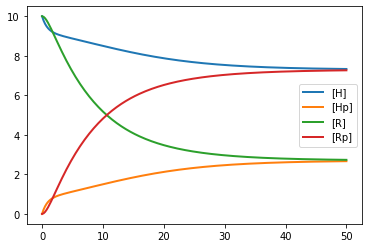

In [31]:
model_twocomp = te.loada(f"""
model pcycle()
  v1: H -> Hp; k1*S*H;
  v2: Hp + R -> H + Rp; k2*R*Hp;
  v3: Rp -> R; k3 * Rp;
  
  // initial values
  H = 10.0; Hp = 0.0;
  R = 10.0; Rp = 0.0;
  
  // parameters
  S = 1.0;
  k1 = 0.1; k2 = 0.1; k3 = 0.1;
  
  // rules
  Ht := H + Hp
  Rt := R + Rp
end
""")
model_twocomp.simulate(start=0, end=50, steps=200)
model_twocomp.plot()

**Perfect adaption** 
- integral feedback
- TODO: equation & test the system;

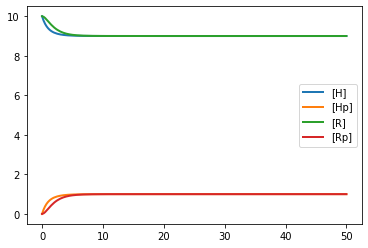

AttributeError: 'NoneType' object has no attribute 'AGraph'

In [35]:
model_tcperfect = te.loada(f"""
model pcycle()
  v1: H -> Hp; k1*S*H;
  v2: Hp + R -> H + Rp; k2*R*Hp;
  v3: Rp -> R; k3 * Rp * H;
  
  // initial values
  H = 10.0; Hp = 0.0;
  R = 10.0; Rp = 0.0;
  
  // parameters
  S = 1.0;
  k1 = 0.1; k2 = 0.1; k3 = 0.1;
  
  // rules
  Ht := H + Hp
  Rt := R + Rp
end
""")

model_tcperfect.simulate(start=0, end=50, steps=200)
model_tcperfect.plot()

Compare steady state solution for response regulator
- numerical solution

# MAPK
## Kholodenko2000 - Ultrasensitivity and negative feedback bring oscillations in MAPK cascade

This model is described in the article:  
**Negative feedback and ultrasensitivity can bring about oscillations in the mitogen-activated protein kinase cascades.**  
Kholodenko BN  
Eur. J. Biochem. 2000; 267(6):1583-8  
http://identifiers.org/pubmed/10712587  

Abstract:

Functional organization of signal transduction into protein phosphorylation cascades, such as the mitogen-activated protein kinase (MAPK) cascades, greatly enhances the sensitivity of cellular targets to external stimuli. The sensitivity increases multiplicatively with the number of cascade levels, so that a tiny change in a stimulus results in a large change in the response, the phenomenon referred to as ultrasensitivity. In a variety of cell types, the MAPK cascades are imbedded in long feedback loops, positive or negative, depending on whether the terminal kinase stimulates or inhibits the activation of the initial level. Here we demonstrate that a negative feedback loop combined with intrinsic ultrasensitivity of the MAPK cascade can bring about sustained oscillations in MAPK phosphorylation. Based on recent kinetic data on the MAPK cascades, we predict that the period of oscillations can range from minutes to hours. The phosphorylation level can vary between the base level and almost 100% of the total protein. The oscillations of the phosphorylation cascades and slow protein diffusion in the cytoplasm can lead to intracellular waves of phospho-proteins.

https://www.ebi.ac.uk/biomodels-main/BIOMD0000000010


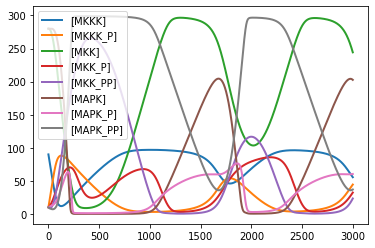

In [14]:
import tellurium as te

# Load model from biomodels (may not work with https).
r = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels-main/download?mid=BIOMD0000000010")
result = r.simulate(start=0, end=3000, steps=3000)
r.plot(result)

In [15]:
print(te.sbmlToAntimony(r.getSBML()))

// Created by libAntimony v2.11.0
model *BIOMD0000000010()

  // Compartments and Species:
  compartment uVol;
  species MKKK in uVol, MKKK_P in uVol, MKK in uVol, MKK_P in uVol, MKK_PP in uVol;
  species MAPK in uVol, MAPK_P in uVol, MAPK_PP in uVol;

  // Reactions:
  J0: MKKK => MKKK_P; uVol*J0_V1*MKKK/((1 + (MAPK_PP/J0_Ki)^J0_n)*(J0_K1 + MKKK));
  J1: MKKK_P => MKKK; uVol*J1_V2*MKKK_P/(J1_KK2 + MKKK_P);
  J2: MKK => MKK_P; uVol*J2_k3*MKKK_P*MKK/(J2_KK3 + MKK);
  J3: MKK_P => MKK_PP; uVol*J3_k4*MKKK_P*MKK_P/(J3_KK4 + MKK_P);
  J4: MKK_PP => MKK_P; uVol*J4_V5*MKK_PP/(J4_KK5 + MKK_PP);
  J5: MKK_P => MKK; uVol*J5_V6*MKK_P/(J5_KK6 + MKK_P);
  J6: MAPK => MAPK_P; uVol*J6_k7*MKK_PP*MAPK/(J6_KK7 + MAPK);
  J7: MAPK_P => MAPK_PP; uVol*J7_k8*MKK_PP*MAPK_P/(J7_KK8 + MAPK_P);
  J8: MAPK_PP => MAPK_P; uVol*J8_V9*MAPK_PP/(J8_KK9 + MAPK_PP);
  J9: MAPK_P => MAPK; uVol*J9_V10*MAPK_P/(J9_KK10 + MAPK_P);

  // Species initializations:
  MKKK = 90;
  MKKK_P = 10;
  MKK = 280;
  MKK_P = 10;
  MKK_PP 